In [1]:
import timm
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn.functional as F
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
# Constants

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64
EPOCHS = 50
RANDOM_SEED = 44

data_dir = '/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset'
stats_dir = '/kaggle/input/stats-liver/stats_liver (1).csv'
generator = torch.Generator().manual_seed(RANDOM_SEED)

df = pd.read_csv(stats_dir)
MEAN = list(df['Mean'])
STD = list(df['Standard Deviation'])

print(f'Mean: {MEAN}\nSTD: {STD}')

TRANSFORMS = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

Mean: [0.083514534, 0.083514534, 0.083514534]
STD: [0.13147554, 0.13147554, 0.13147554]


In [3]:
# Seed environment

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
# Data

dataset = datasets.ImageFolder(data_dir, transform=TRANSFORMS)
train_set, val_set, test_set = random_split(dataset, [0.8, 0.1, 0.1], generator=generator)
print(f'Train: {len(train_set)}\nVal:{len(val_set)}\nTest: {len(test_set)}')

Train: 5059
Val:632
Test: 632


In [5]:
# Modules

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
            "hf_hub:timm/vit_base_patch16_224.augreg2_in21k_ft_in1k",
            features_only=True,
            pretrained=False
        )

    def forward(self, x):
        feats = self.backbone(x)[-1]
        return feats

class ProjectionHead(nn.Module):
    def __init__(self, in_dim=768):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(in_dim, 384),
            nn.BatchNorm1d(384),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(384, 192),
            nn.BatchNorm1d(192),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        return self.head(x)

class Classifier(nn.Module):
    def __init__(self, in_dim=192):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(in_dim, 96),
            nn.BatchNorm1d(96),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(96, 5),
            nn.BatchNorm1d(5),
            nn.Dropout(0.1)
        )
        self._initialize_weights()

    def forward(self, x):
        return self.head(x)

    def _initialize_weights(self):
        for m in self.head:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

In [6]:
encoder = Encoder().to(device)
encoder.load_state_dict(torch.load('/kaggle/input/vit-encoder-contrastive-liver/pytorch/default/1/best_encoder_con.pth'))
proj_head = ProjectionHead(in_dim=768).to(device)
proj_head.load_state_dict(torch.load('/kaggle/input/projection-head-contrastive-liver/pytorch/default/1/best_proj_head_con.pth'))
classifier = Classifier().to(device)
optimizer = optim.AdamW(list(encoder.parameters()) + list(proj_head.parameters()) + list(classifier.parameters()), lr=5e-5, weight_decay=1e-4)
counts = torch.tensor([2114,861,793,857,1698], dtype=torch.float32).to(device)
class_weights = 1.0 / counts
class_weights = class_weights / class_weights.mean()
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

config.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

In [7]:
# Training

PATIENCE = 5
min_loss = float('inf')
bad_epochs = 0
MIN_DELTA = 0.05

train_loss_array = []
val_loss_array = []

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=3, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=3, pin_memory=True, shuffle=False)

for epoch in range(EPOCHS):
    print(f'Epoch: {epoch + 1}/{EPOCHS}')
    encoder.train()
    proj_head.train()
    classifier.train()
    train_loss_total = 0
    for imgs, labels in tqdm(train_loader, desc='Training'):
        imgs, labels = imgs.to(device), labels.to(device)
        features = torch.mean(encoder(imgs), dim=(2, 3))
        proj_features = proj_head(features)
        logits = classifier(proj_features)
        loss = loss_fn(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_total += loss.item()

    train_loss = train_loss_total / len(train_loader) 

    encoder.eval()
    proj_head.eval()
    classifier.eval()
    val_loss_total = 0
    with torch.inference_mode():
        for imgs, labels in tqdm(val_loader, desc='Validation'):
            imgs, labels = imgs.to(device), labels.to(device)
            features = torch.mean(encoder(imgs), dim=(2, 3))
            proj_features = proj_head(features)
            logits = classifier(proj_features)
            loss = loss_fn(logits, labels)
            val_loss_total += loss.item()
    
    val_loss = val_loss_total / len(val_loader)

    print(f'Training Loss: {train_loss}, Validation Loss: {val_loss}')
    train_loss_array.append(train_loss)
    val_loss_array.append(val_loss)

    if val_loss > min_loss * (1 + MIN_DELTA):
        bad_epochs += 1

    elif val_loss < min_loss:
        bad_epochs = 0
        torch.save(encoder.state_dict(), 'best_encoder_con_classification.pth')
        torch.save(proj_head.state_dict(), 'best_proj_head_con_classification.pth')
        torch.save(classifier.state_dict(), 'best_classifier_con.pth')

    else:
        bad_epochs = 0

    if bad_epochs >= PATIENCE:
        print('Early stopping triggered!')
        break

Epoch: 1/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Training Loss: 0.8136845320463181, Validation Loss: 0.4301887691020966
Epoch: 2/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


Training Loss: 0.4725751880556345, Validation Loss: 0.44079608619213106
Epoch: 3/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Training Loss: 0.4865289509296417, Validation Loss: 0.38561477363109586
Epoch: 4/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Training Loss: 0.43881774209439756, Validation Loss: 0.3929278254508972
Epoch: 5/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


Training Loss: 0.43819491639733316, Validation Loss: 0.38095444440841675
Epoch: 6/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


Training Loss: 0.4171523667871952, Validation Loss: 0.3645636588335037
Epoch: 7/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Training Loss: 0.4101603653281927, Validation Loss: 0.36456996500492095
Epoch: 8/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Training Loss: 0.4066379476338625, Validation Loss: 0.3529410421848297
Epoch: 9/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


Training Loss: 0.40715086087584496, Validation Loss: 0.39720076620578765
Epoch: 10/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


Training Loss: 0.39501255229115484, Validation Loss: 0.38256412744522095
Epoch: 11/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Training Loss: 0.39380378983914854, Validation Loss: 0.3356519162654877
Epoch: 12/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Training Loss: 0.390999698266387, Validation Loss: 0.38642204999923707
Epoch: 13/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


Training Loss: 0.3796954985707998, Validation Loss: 0.3619516879320145
Epoch: 14/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


Training Loss: 0.37679189518094064, Validation Loss: 0.36252119243144987
Epoch: 15/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


Training Loss: 0.37030495069921016, Validation Loss: 0.3377980262041092
Epoch: 16/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


Training Loss: 0.37124987319111824, Validation Loss: 0.35760284662246705
Epoch: 17/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


Training Loss: 0.3644692189991474, Validation Loss: 0.370314484834671
Epoch: 18/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Training Loss: 0.37268555648624896, Validation Loss: 0.31359133720397947
Epoch: 19/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Training Loss: 0.380849776417017, Validation Loss: 0.31071110516786576
Epoch: 20/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


Training Loss: 0.3666005525738001, Validation Loss: 0.3478644162416458
Epoch: 21/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


Training Loss: 0.37855403535068033, Validation Loss: 0.34094885885715487
Epoch: 22/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


Training Loss: 0.361757954582572, Validation Loss: 0.32840012907981875
Epoch: 23/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Training Loss: 0.37122724000364543, Validation Loss: 0.3271869033575058
Epoch: 24/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


Training Loss: 0.35665431767702105, Validation Loss: 0.303484109044075
Epoch: 25/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


Training Loss: 0.3557694237679243, Validation Loss: 0.34092154502868655
Epoch: 26/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


Training Loss: 0.3500373691320419, Validation Loss: 0.32864221930503845
Epoch: 27/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


Training Loss: 0.36443335730582477, Validation Loss: 0.34149119555950164
Epoch: 28/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Training Loss: 0.38551874589174984, Validation Loss: 0.3031523019075394
Epoch: 29/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


Training Loss: 0.3468573890626431, Validation Loss: 0.33876430690288545
Epoch: 30/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Training Loss: 0.3464213082566857, Validation Loss: 0.33161987364292145
Epoch: 31/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


Training Loss: 0.36082639787346127, Validation Loss: 0.3788460731506348
Epoch: 32/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


Training Loss: 0.3490123156458139, Validation Loss: 0.3602096140384674
Epoch: 33/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Training Loss: 0.3620824541896582, Validation Loss: 0.31715404242277145
Epoch: 34/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


Training Loss: 0.3379249718040228, Validation Loss: 0.34171133637428286
Epoch: 35/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


Training Loss: 0.3359487963840365, Validation Loss: 0.28385060131549833
Epoch: 36/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Training Loss: 0.3685162544250488, Validation Loss: 0.32037845253944397
Epoch: 37/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Training Loss: 0.34578686244785783, Validation Loss: 0.33600151538848877
Epoch: 38/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


Training Loss: 0.3478298030793667, Validation Loss: 0.30187162607908247
Epoch: 39/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


Training Loss: 0.3230247164145112, Validation Loss: 0.2992792874574661
Epoch: 40/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


Training Loss: 0.3339511722326279, Validation Loss: 0.3072246477007866
Epoch: 41/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


Training Loss: 0.31711087506264446, Validation Loss: 0.3042706951498985
Epoch: 42/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Training Loss: 0.31375751588493583, Validation Loss: 0.31909932792186735
Epoch: 43/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


Training Loss: 0.3217119244858623, Validation Loss: 0.31364783346652986
Epoch: 44/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


Training Loss: 0.32921863831579684, Validation Loss: 0.27446067035198213
Epoch: 45/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


Training Loss: 0.33597895316779613, Validation Loss: 0.28830978870391843
Epoch: 46/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


Training Loss: 0.3206369332969189, Validation Loss: 0.28352864682674406
Epoch: 47/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Training Loss: 0.302945426478982, Validation Loss: 0.315316279232502
Epoch: 48/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


Training Loss: 0.3228835079818964, Validation Loss: 0.2899758592247963
Epoch: 49/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Training Loss: 0.31435801070183517, Validation Loss: 0.26072861552238463
Epoch: 50/50


Validation: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


Training Loss: 0.3422222388908267, Validation Loss: 0.2999483272433281


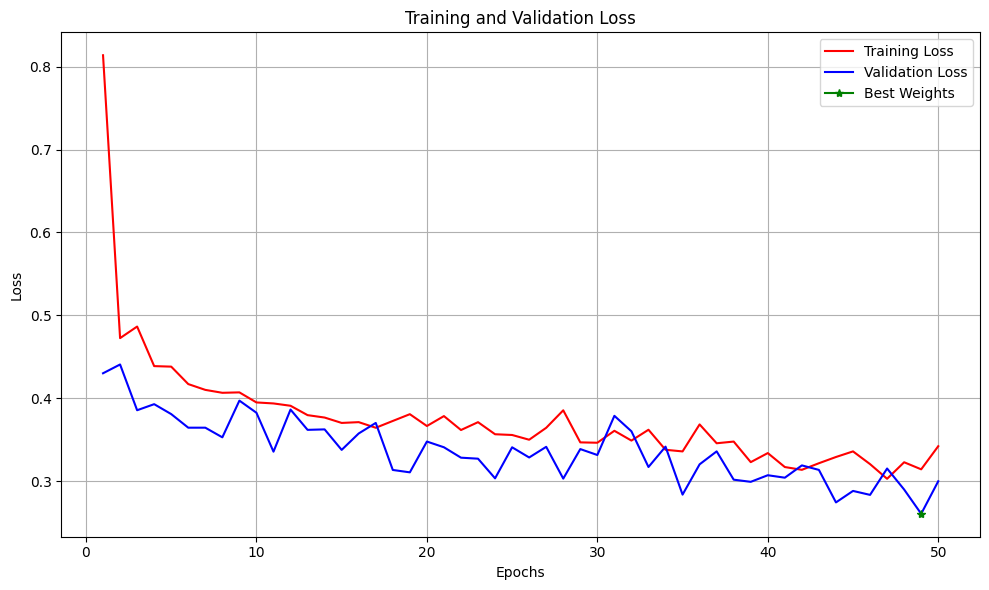

In [8]:
# plot

train_loss_array = np.array(train_loss_array)
val_loss_array = np.array(val_loss_array)
best_weights = np.argmin(val_loss_array)

t = [i + 1 for i in range(len(train_loss_array))]

plt.figure(figsize=(10, 6))
plt.plot(t, train_loss_array, label='Training Loss', color='red')
plt.plot(t, val_loss_array, label='Validation Loss', color='blue')
plt.plot(best_weights + 1, val_loss_array[best_weights], label='Best Weights', color='green', marker='*')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('vit_classification_loss_fig.pdf', bbox_inches='tight', format='pdf', dpi=600)
plt.show()